# VoxelMorph

## Proposed Method Description
$\href {https://arxiv.org/pdf/1809.05231}{Voxelmorph}$ framework, which is designed for image registration using deep learning. Image registration is the process of aligning different images into a common coordinate system. Voxelmorph leverages unsupervised learning to register images by minimizing a loss function that reflects spatial correspondence between images.

Voxelmorph employs a convolutional neural network to predict a deformation field that maps one image to another. The deformation field represents how the pixels in one image should be displaced to align with another image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
import time
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal
from torch.autograd import Variable
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import math

!pip install monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.apps import MedNISTDataset
import tempfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.8 MB/s eta 0:00:00


# DATALOADER

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.47.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/l

MedNIST.tar.gz: 59.0MB [00:02, 28.1MB/s]                            

2024-12-21 07:26:32,081 - INFO - Downloaded: /tmp/tmpzf5osmja/MedNIST.tar.gz


2024-12-21 07:26:32,466 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-12-21 07:26:32,472 - INFO - Writing into directory: /tmp/tmpzf5osmja.


Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 94621.18it/s]



 first training items:  [{'fixed_hand': '/tmp/tmpzf5osmja/MedNIST/Hand/003836.jpeg', 'moving_hand': '/tmp/tmpzf5osmja/MedNIST/Hand/003836.jpeg'}, {'fixed_hand': '/tmp/tmpzf5osmja/MedNIST/Hand/001613.jpeg', 'moving_hand': '/tmp/tmpzf5osmja/MedNIST/Hand/001613.jpeg'}, {'fixed_hand': '/tmp/tmpzf5osmja/MedNIST/Hand/008693.jpeg', 'moving_hand': '/tmp/tmpzf5osmja/MedNIST/Hand/008693.jpeg'}]
moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


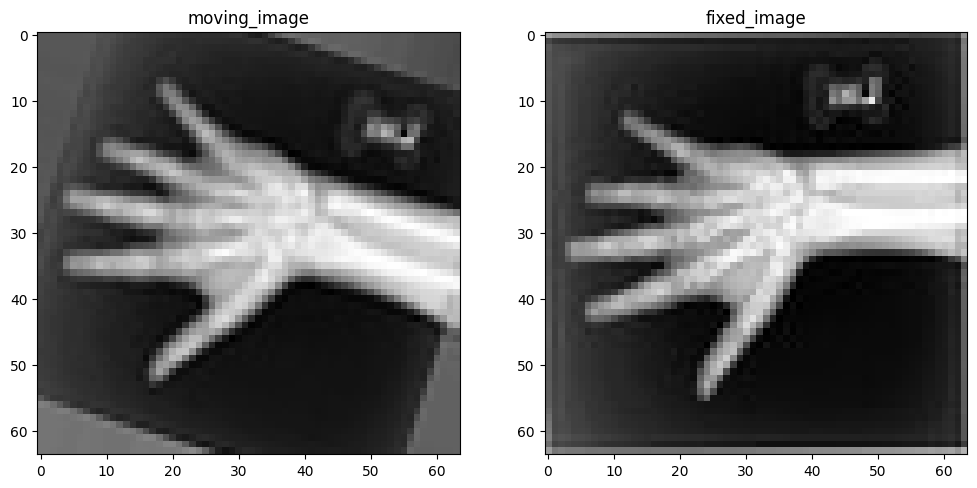

Loading dataset: 100%|██████████| 500/500 [00:01<00:00, 335.69it/s]


In [2]:
print_config()
set_determinism(42)
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)


train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data
    if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])

train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"]),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRanged(
            keys=["fixed_hand", "moving_hand"],
            a_min=0.0,
            a_max=255.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RandRotateD(keys=["moving_hand"], range_x=np.pi / 4, prob=1.0, keep_size=True, mode="bicubic"),
        RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
    ]
)

check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed_hand"][0][0]
moving_image = check_data["moving_hand"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()


train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)

# U-NET

`Encoder-Decoder Network`: The model takes two images as input: a moving image and a fixed image. It outputs the deformation field that aligns the moving image to the fixed one.

<p align="left">
<img src="https://drive.usercontent.google.com/u/0/uc?id=14S29efIg5RZsZ7b0Mm9ucWLKUagVn0N5&export=download" alt="" width="500"/>
</p>

The Voxelmorph model consists of a convolutional encoder-decoder architecture:
- Encoder: Extracts features from the input images using convolutions and pooling layers.
- Decoder: Upsamples the encoded features to generate the deformation field that aligns the images.
- Flow Field: The final output is a deformation field.
Input/Output:

In [3]:
class Unet(nn.Module):
    """
    A unet architecture. Layer features can be specified directly as a list of encoder and decoder
    features or as a single integer along with a number of unet levels. The default network features
    per layer (when no options are specified) are:

        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]
    """

    def __init__(self,
                 inshape=None,
                 infeats=None,
                 nb_features=None,
                 nb_levels=None,
                 max_pool=2,
                 feat_mult=1,
                 nb_conv_per_level=1,
                 half_res=False):
        """
        Parameters:
            inshape: Input shape. e.g. (1, 64, 64)
            infeats: Number of input features.
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer.
                If None (default), the unet features are defined by the default config described in
                the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer.
                Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer.
                Default is 1.
            nb_conv_per_level: Number of convolutions per unet level. Default is 1.
            half_res: Skip the last decoder upsampling. Default is False.
        """

        super().__init__()

        # ensure correct dimensionality
        ndims = 2

        # cache some parameters
        self.half_res = half_res

        # default encoder and decoder layer features if nothing provided
        if nb_features is None:
            nb_features = default_unet_features()

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            nb_features = [
                np.repeat(feats[:-1], nb_conv_per_level),
                np.repeat(np.flip(feats), nb_conv_per_level)
            ]
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')

        # extract any surplus (full resolution) decoder convolutions
        enc_nf, dec_nf = nb_features
        nb_dec_convs = len(enc_nf)
        final_convs = dec_nf[nb_dec_convs:]
        dec_nf = dec_nf[:nb_dec_convs]
        self.nb_levels = int(nb_dec_convs / nb_conv_per_level) + 1

        if isinstance(max_pool, int):
            max_pool = [max_pool] * self.nb_levels

        # cache downsampling / upsampling operations
        MaxPooling = getattr(nn, 'MaxPool%dd' % ndims)
        self.pooling = [MaxPooling(s) for s in max_pool]
        self.upsampling = [nn.Upsample(scale_factor=s, mode='nearest') for s in max_pool]

        # configure encoder (down-sampling path)
        prev_nf = infeats
        encoder_nfs = [prev_nf]
        self.encoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = enc_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.encoder.append(convs)
            encoder_nfs.append(prev_nf)

        # configure decoder (up-sampling path)
        encoder_nfs = np.flip(encoder_nfs)
        self.decoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = dec_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.decoder.append(convs)
            if not half_res or level < (self.nb_levels - 2):
                prev_nf += encoder_nfs[level]

        # now we take care of any remaining convolutions
        self.remaining = nn.ModuleList()
        for num, nf in enumerate(final_convs):
            self.remaining.append(ConvBlock(ndims, prev_nf, nf))
            prev_nf = nf

        # cache final number of features
        self.final_nf = prev_nf

    def forward(self, x):

        # encoder forward pass
        x_history = [x]
        for level, convs in enumerate(self.encoder):
            for conv in convs:
                x = conv(x)
            x_history.append(x)
            x = self.pooling[level](x)

        # decoder forward pass with upsampling and concatenation
        for level, convs in enumerate(self.decoder):
            for conv in convs:
                x = conv(x)
            if not self.half_res or level < (self.nb_levels - 2):
                x = self.upsampling[level](x)
                x = torch.cat([x, x_history.pop()], dim=1)

        # remaining convs at full resolution
        for conv in self.remaining:
            x = conv(x)

        return x


class VxmDense(nn.Module):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    def __init__(self,
                 inshape,
                 nb_unet_features=None,
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 nb_unet_conv_per_level=1,
                 int_steps=7,
                 int_downsize=2,
                 use_probs=False,
                 src_feats=1,
                 trg_feats=1,
                 unet_half_res=False):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer.
                If None (default), the unet features are defined by the default config described in
                the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_features is an integer.
                Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_features is an integer.
                Default is 1.
            nb_unet_conv_per_level: Number of convolutions per unet level. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this
                value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration.
                The flow field is not downsampled when this value is 1.
            use_probs: Use probabilities in flow field. Default is False.
            src_feats: Number of source image features.
            trg_feats: Number of target image features.
            unet_half_res: Skip the last unet decoder upsampling. Requires that int_downsize=2.
                Default is False.
        """
        super().__init__()

        # internal flag indicating whether to return flow or integrated warp during inference
        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            infeats=(src_feats + trg_feats),
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult,
            nb_conv_per_level=nb_unet_conv_per_level,
            half_res=unet_half_res,
        )

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.flow = Conv(self.unet_model.final_nf, ndims, kernel_size=3, padding=1)

        # init flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        # probabilities are not supported in pytorch
        if use_probs:
            raise NotImplementedError(
                'Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure optional resize layers (downsize)
        if not unet_half_res and int_steps > 0 and int_downsize > 1:
            self.resize = ResizeTransform(int_downsize, ndims)
        else:
            self.resize = None

        # resize to full res
        if int_steps > 0 and int_downsize > 1:
            self.fullsize = ResizeTransform(1 / int_downsize, ndims)
        else:
            self.fullsize = None


        # configure optional integration layer for diffeomorphic warp
        down_shape = [int(dim / int_downsize) for dim in inshape]
        self.integrate = VecInt(down_shape, int_steps) if int_steps > 0 else None

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, source, target, registration=False):
        '''
        Parameters:
            source: Source image tensor.
            target: Target image tensor.
            registration: Return transformed image and flow. Default is False.
        '''

        # concatenate inputs and propagate unet
        x = torch.cat([source, target], dim=1)
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        # resize flow for integration
        pos_flow = flow_field
        if self.resize:
            pos_flow = self.resize(pos_flow)

        preint_flow = pos_flow

        # integrate to produce diffeomorphic warp
        if self.integrate:
            pos_flow = self.integrate(pos_flow)

            # resize to final resolution
            if self.fullsize:
                pos_flow = self.fullsize(pos_flow)

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)

        # return non-integrated flow field if training
        if not registration:
            return  y_source, preint_flow
        else:
            return y_source, pos_flow


class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.main(x)
        out = self.activation(out)
        return out

import torch
import torch.nn as nn
import torch.nn.functional as nnf


class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nnf.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


class VecInt(nn.Module):
    """
    Integrates a vector field via scaling and squaring.
    """

    def __init__(self, inshape, nsteps):
        super().__init__()

        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(inshape)

    def forward(self, vec):
        vec = vec * self.scale
        for _ in range(self.nsteps):
            vec = vec + self.transformer(vec, vec)
        return vec


class ResizeTransform(nn.Module):
    """
    Resize a transform, which involves resizing the vector field *and* rescaling it.
    """

    def __init__(self, vel_resize, ndims):
        super().__init__()
        self.factor = 1.0 / vel_resize
        self.mode = 'linear'
        if ndims == 2:
            self.mode = 'bi' + self.mode
        elif ndims == 3:
            self.mode = 'tri' + self.mode

    def forward(self, x):
        if self.factor < 1:
            # resize first to save memory
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)
            x = self.factor * x

        elif self.factor > 1:
            # multiply first to save memory
            x = self.factor * x
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)

        return x


# LOSS

The loss function is crucial for training the network and ensures that the predicted deformation aligns the moving image with the fixed image.
The Voxelmorph paper defines two components for the loss:
### Similarity Loss:
`MSE Loss`: This term quantifies how well the aligned images match in terms of pixel intensities.

`Cross correlation loss`: This term quantifies how well the aligned images match in terms of pixel intensities.

<p align="left">
<img src="https://drive.usercontent.google.com/u/0/uc?id=1k1Erq2g06KeAA_P5oj807oBxZ2icGSXy&export=download" alt="" width="500"/>
</p>

### Smooth Loss
`Smoothness Loss (Regularization Loss)`: To prevent unrealistic deformations, the deformation field is regularized to encourage smooth transformations.

$
L_{\text{smooth}}(\mathbf{\phi}) = \sum_{p \in \Omega} \|\nabla \mathbf{p}\|^2
$

This loss penalizes high-frequency deformations, ensuring that the transformation is smooth and continuous.

Total Loss: The total loss is a weighted sum of the image matching loss and the smoothness los

$L_{total} =  L_{similarity} + \lambda \cdot L_{smooth}$

where λ is a regularization weight controlling the trade-off between matching the images and enforcing smooth deformation


` Dice Score `:

<p align="left">
<img src="https://drive.usercontent.google.com/u/0/uc?id=1Bb_K1GYhFY8b5rmobZ9FwTHpxrMEZFhl&export=download" alt="" width="500"/>
</p>


## Implimentation
completing each Loss function based on the description on the `VoxelMorph paper`.

In [4]:
def cross_correlation_loss_OR_MSE(y_true, y_pred):
    """
    Calculate the Mean Squared Error (MSE) loss between y_true and y_pred.

    Args:
        y_true: The ground truth image (fixed image).
        y_pred: The predicted image (moved image).

    Returns:
        The MSE loss.
    """
    diff = y_true - y_pred
    return (diff ** 2).mean()

def smoothing_loss(y_pred):
    """
    Calculate the smoothing loss (regularization loss) of the deformation field.

    Args:
        y_pred: The predicted deformation field.

    Returns:
        The smoothing loss.
    """
    dy = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
    dx = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])

    return (dx ** 2).sum() / dx.numel() + (dy ** 2).sum() / dy.numel()


def dice_score(target, pred):
    """
    Calculate the Dice score between the target and predicted segmentation masks.

    Args:
        target: The ground truth segmentation mask.
        pred: The predicted segmentation mask.

    Returns:
        The Dice score.
    """
    smooth = 1.0

    target_flat = target.view(-1)
    pred_flat = pred.view(-1)

    intersection = (target_flat * pred_flat).sum().item()
    union = target_flat.sum().item() + pred_flat.sum().item()

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

In [5]:
class VoxelLoss(nn.Module):
  def __init__(self):
    super(VoxelLoss, self).__init__()

  def forward(self, true, pred, dff):
    cor = cross_correlation_loss_OR_MSE(true, pred)
    smooth = smoothing_loss(dff)
    return   cor + 0.001 * smooth

criterion = VoxelLoss()

# TRAIN

In [6]:
inshape=[64,64]
enc_nf =  [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

voxelmorph = VxmDense(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(voxelmorph.parameters(), lr=1e-5)
voxelmorph = voxelmorph.to(device)

num_epochs = 200  # You can change number of epochs

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_dice_score, val_loss, val_dice_score = 0, 0, 0, 0
    num_train_batches, num_val_batches = len(train_loader), len(val_loader)

    voxelmorph.train()
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training')

    for batch in train_loader_tqdm:
        batch_fixed, batch_moving = batch['fixed_hand'].to(device), batch['moving_hand'].to(device)

        optimizer.zero_grad()

        registered_image, dff = voxelmorph(batch_moving, batch_fixed)

        loss = criterion(batch_fixed, registered_image, dff)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice_score += dice_score(batch_fixed, registered_image)

        # Update progress bar
        train_loader_tqdm.set_postfix(loss=loss.item())
        train_loader_tqdm.update()

    train_loss /= num_train_batches
    train_dice_score /= num_train_batches

    # Validation Phase
    voxelmorph.eval()
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation')
    with torch.no_grad():

        for batch in val_loader_tqdm:
            batch_fixed, batch_moving = batch['fixed_hand'].to(device), batch['moving_hand'].to(device)

            registered_image, dff = voxelmorph(batch_moving, batch_fixed)

            loss = criterion(batch_fixed, registered_image, dff)

            val_loss += loss.item()
            val_dice_score += dice_score(batch_fixed, registered_image)

            # Update progress bar
            val_loader_tqdm.set_postfix(val_loss=val_loss / (val_loader_tqdm.n + 1))
            val_loader_tqdm.update()

    val_loss /= num_val_batches
    val_dice_score /= num_val_batches

    # Print epoch summary
    epoch_duration = (time.time() - epoch_start_time) / 60
    print(f"Epoch {epoch + 1}/{num_epochs} - Duration: {epoch_duration:.2f} mins - Train Loss: {train_loss:.3f}, Train DICE: {train_dice_score:.3f}, Val Loss: {val_loss:.3f}, Val DICE: {val_dice_score:.3f}")

Epoch 1/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, val_loss=0.0716]


Epoch 1/200 - Duration: 0.33 mins - Train Loss: 0.089, Train DICE: 0.478, Val Loss: 0.089, Val DICE: 0.490


Epoch 2/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s, val_loss=0.0699]


Epoch 2/200 - Duration: 0.31 mins - Train Loss: 0.093, Train DICE: 0.470, Val Loss: 0.090, Val DICE: 0.490


Epoch 3/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s, val_loss=0.073]


Epoch 3/200 - Duration: 0.38 mins - Train Loss: 0.090, Train DICE: 0.475, Val Loss: 0.091, Val DICE: 0.488


Epoch 4/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s, val_loss=0.0722]


Epoch 4/200 - Duration: 0.36 mins - Train Loss: 0.093, Train DICE: 0.469, Val Loss: 0.092, Val DICE: 0.483


Epoch 5/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s, val_loss=0.0707]


Epoch 5/200 - Duration: 0.35 mins - Train Loss: 0.090, Train DICE: 0.472, Val Loss: 0.088, Val DICE: 0.488


Epoch 6/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, val_loss=0.0736]


Epoch 6/200 - Duration: 0.36 mins - Train Loss: 0.088, Train DICE: 0.474, Val Loss: 0.092, Val DICE: 0.482


Epoch 7/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s, val_loss=0.0724]


Epoch 7/200 - Duration: 0.32 mins - Train Loss: 0.090, Train DICE: 0.470, Val Loss: 0.090, Val DICE: 0.484


Epoch 8/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s, val_loss=0.072]


Epoch 8/200 - Duration: 0.33 mins - Train Loss: 0.088, Train DICE: 0.472, Val Loss: 0.090, Val DICE: 0.485


Epoch 9/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s, val_loss=0.0713]


Epoch 9/200 - Duration: 0.34 mins - Train Loss: 0.091, Train DICE: 0.467, Val Loss: 0.091, Val DICE: 0.482


Epoch 10/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s, val_loss=0.0708]


Epoch 10/200 - Duration: 0.42 mins - Train Loss: 0.087, Train DICE: 0.474, Val Loss: 0.089, Val DICE: 0.486


Epoch 11/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.24it/s, val_loss=0.0693]


Epoch 11/200 - Duration: 0.31 mins - Train Loss: 0.090, Train DICE: 0.469, Val Loss: 0.087, Val DICE: 0.489


Epoch 12/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s, val_loss=0.0652]


Epoch 12/200 - Duration: 0.33 mins - Train Loss: 0.089, Train DICE: 0.470, Val Loss: 0.084, Val DICE: 0.494


Epoch 13/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s, val_loss=0.0678]


Epoch 13/200 - Duration: 0.33 mins - Train Loss: 0.088, Train DICE: 0.472, Val Loss: 0.087, Val DICE: 0.489


Epoch 14/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s, val_loss=0.0683]


Epoch 14/200 - Duration: 0.33 mins - Train Loss: 0.088, Train DICE: 0.473, Val Loss: 0.085, Val DICE: 0.491


Epoch 15/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s, val_loss=0.0702]


Epoch 15/200 - Duration: 0.32 mins - Train Loss: 0.088, Train DICE: 0.472, Val Loss: 0.090, Val DICE: 0.483


Epoch 16/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, val_loss=0.0716]


Epoch 16/200 - Duration: 0.37 mins - Train Loss: 0.090, Train DICE: 0.468, Val Loss: 0.090, Val DICE: 0.484


Epoch 17/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s, val_loss=0.0716]


Epoch 17/200 - Duration: 0.32 mins - Train Loss: 0.091, Train DICE: 0.467, Val Loss: 0.089, Val DICE: 0.483


Epoch 18/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, val_loss=0.0715]


Epoch 18/200 - Duration: 0.40 mins - Train Loss: 0.088, Train DICE: 0.471, Val Loss: 0.089, Val DICE: 0.483


Epoch 19/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, val_loss=0.0678]


Epoch 19/200 - Duration: 0.33 mins - Train Loss: 0.089, Train DICE: 0.470, Val Loss: 0.087, Val DICE: 0.487


Epoch 20/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s, val_loss=0.0668]


Epoch 20/200 - Duration: 0.35 mins - Train Loss: 0.088, Train DICE: 0.470, Val Loss: 0.086, Val DICE: 0.489


Epoch 21/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s, val_loss=0.0689]


Epoch 21/200 - Duration: 0.35 mins - Train Loss: 0.089, Train DICE: 0.469, Val Loss: 0.086, Val DICE: 0.488


Epoch 22/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s, val_loss=0.0719]


Epoch 22/200 - Duration: 0.31 mins - Train Loss: 0.087, Train DICE: 0.472, Val Loss: 0.090, Val DICE: 0.482


Epoch 23/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s, val_loss=0.0663]


Epoch 23/200 - Duration: 0.33 mins - Train Loss: 0.089, Train DICE: 0.468, Val Loss: 0.085, Val DICE: 0.489


Epoch 24/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s, val_loss=0.07]


Epoch 24/200 - Duration: 0.34 mins - Train Loss: 0.086, Train DICE: 0.472, Val Loss: 0.088, Val DICE: 0.484


Epoch 25/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s, val_loss=0.0658]


Epoch 25/200 - Duration: 0.38 mins - Train Loss: 0.086, Train DICE: 0.469, Val Loss: 0.084, Val DICE: 0.485


Epoch 26/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s, val_loss=0.0615]


Epoch 26/200 - Duration: 0.35 mins - Train Loss: 0.082, Train DICE: 0.468, Val Loss: 0.077, Val DICE: 0.490


Epoch 27/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, val_loss=0.0563]


Epoch 27/200 - Duration: 0.35 mins - Train Loss: 0.073, Train DICE: 0.485, Val Loss: 0.072, Val DICE: 0.503


Epoch 28/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s, val_loss=0.0529]


Epoch 28/200 - Duration: 0.31 mins - Train Loss: 0.069, Train DICE: 0.493, Val Loss: 0.066, Val DICE: 0.510


Epoch 29/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=0.0475]


Epoch 29/200 - Duration: 0.33 mins - Train Loss: 0.065, Train DICE: 0.500, Val Loss: 0.061, Val DICE: 0.521


Epoch 30/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, val_loss=0.0487]


Epoch 30/200 - Duration: 0.34 mins - Train Loss: 0.062, Train DICE: 0.506, Val Loss: 0.062, Val DICE: 0.517


Epoch 31/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s, val_loss=0.0464]


Epoch 31/200 - Duration: 0.33 mins - Train Loss: 0.062, Train DICE: 0.504, Val Loss: 0.059, Val DICE: 0.521


Epoch 32/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s, val_loss=0.0452]


Epoch 32/200 - Duration: 0.35 mins - Train Loss: 0.059, Train DICE: 0.509, Val Loss: 0.058, Val DICE: 0.523


Epoch 33/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s, val_loss=0.0436]


Epoch 33/200 - Duration: 0.41 mins - Train Loss: 0.058, Train DICE: 0.511, Val Loss: 0.056, Val DICE: 0.526


Epoch 34/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s, val_loss=0.0419]


Epoch 34/200 - Duration: 0.34 mins - Train Loss: 0.054, Train DICE: 0.517, Val Loss: 0.054, Val DICE: 0.531


Epoch 35/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, val_loss=0.0398]


Epoch 35/200 - Duration: 0.33 mins - Train Loss: 0.053, Train DICE: 0.518, Val Loss: 0.051, Val DICE: 0.535


Epoch 36/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s, val_loss=0.0404]


Epoch 36/200 - Duration: 0.34 mins - Train Loss: 0.051, Train DICE: 0.521, Val Loss: 0.050, Val DICE: 0.535


Epoch 37/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, val_loss=0.0393]


Epoch 37/200 - Duration: 0.36 mins - Train Loss: 0.050, Train DICE: 0.526, Val Loss: 0.049, Val DICE: 0.539


Epoch 38/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s, val_loss=0.0386]


Epoch 38/200 - Duration: 0.31 mins - Train Loss: 0.048, Train DICE: 0.530, Val Loss: 0.048, Val DICE: 0.543


Epoch 39/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, val_loss=0.038]


Epoch 39/200 - Duration: 0.32 mins - Train Loss: 0.047, Train DICE: 0.533, Val Loss: 0.048, Val DICE: 0.545


Epoch 40/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s, val_loss=0.0361]


Epoch 40/200 - Duration: 0.38 mins - Train Loss: 0.045, Train DICE: 0.539, Val Loss: 0.045, Val DICE: 0.550


Epoch 41/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, val_loss=0.0351]


Epoch 41/200 - Duration: 0.34 mins - Train Loss: 0.045, Train DICE: 0.538, Val Loss: 0.044, Val DICE: 0.554


Epoch 42/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s, val_loss=0.0349]


Epoch 42/200 - Duration: 0.30 mins - Train Loss: 0.045, Train DICE: 0.540, Val Loss: 0.044, Val DICE: 0.555


Epoch 43/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s, val_loss=0.0343]


Epoch 43/200 - Duration: 0.33 mins - Train Loss: 0.043, Train DICE: 0.546, Val Loss: 0.044, Val DICE: 0.556


Epoch 44/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s, val_loss=0.0329]


Epoch 44/200 - Duration: 0.32 mins - Train Loss: 0.043, Train DICE: 0.546, Val Loss: 0.042, Val DICE: 0.560


Epoch 45/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.47it/s, val_loss=0.0335]


Epoch 45/200 - Duration: 0.34 mins - Train Loss: 0.043, Train DICE: 0.546, Val Loss: 0.042, Val DICE: 0.561


Epoch 46/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s, val_loss=0.0332]


Epoch 46/200 - Duration: 0.37 mins - Train Loss: 0.042, Train DICE: 0.549, Val Loss: 0.041, Val DICE: 0.562


Epoch 47/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s, val_loss=0.0332]


Epoch 47/200 - Duration: 0.33 mins - Train Loss: 0.041, Train DICE: 0.553, Val Loss: 0.041, Val DICE: 0.563


Epoch 48/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s, val_loss=0.0321]


Epoch 48/200 - Duration: 0.39 mins - Train Loss: 0.040, Train DICE: 0.555, Val Loss: 0.040, Val DICE: 0.567


Epoch 49/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s, val_loss=0.0313]


Epoch 49/200 - Duration: 0.37 mins - Train Loss: 0.040, Train DICE: 0.554, Val Loss: 0.039, Val DICE: 0.569


Epoch 50/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.23it/s, val_loss=0.0318]


Epoch 50/200 - Duration: 0.38 mins - Train Loss: 0.040, Train DICE: 0.555, Val Loss: 0.040, Val DICE: 0.567


Epoch 51/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s, val_loss=0.0321]


Epoch 51/200 - Duration: 0.37 mins - Train Loss: 0.040, Train DICE: 0.557, Val Loss: 0.040, Val DICE: 0.567


Epoch 52/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.85it/s, val_loss=0.0325]


Epoch 52/200 - Duration: 0.35 mins - Train Loss: 0.040, Train DICE: 0.556, Val Loss: 0.041, Val DICE: 0.566


Epoch 53/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s, val_loss=0.0314]


Epoch 53/200 - Duration: 0.36 mins - Train Loss: 0.039, Train DICE: 0.559, Val Loss: 0.039, Val DICE: 0.569


Epoch 54/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s, val_loss=0.0303]


Epoch 54/200 - Duration: 0.35 mins - Train Loss: 0.039, Train DICE: 0.560, Val Loss: 0.038, Val DICE: 0.572


Epoch 55/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s, val_loss=0.0309]


Epoch 55/200 - Duration: 0.44 mins - Train Loss: 0.039, Train DICE: 0.560, Val Loss: 0.039, Val DICE: 0.572


Epoch 56/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.82it/s, val_loss=0.0305]


Epoch 56/200 - Duration: 0.34 mins - Train Loss: 0.039, Train DICE: 0.560, Val Loss: 0.038, Val DICE: 0.572


Epoch 57/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s, val_loss=0.0298]


Epoch 57/200 - Duration: 0.35 mins - Train Loss: 0.038, Train DICE: 0.560, Val Loss: 0.037, Val DICE: 0.573


Epoch 58/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, val_loss=0.0305]


Epoch 58/200 - Duration: 0.37 mins - Train Loss: 0.037, Train DICE: 0.563, Val Loss: 0.038, Val DICE: 0.572


Epoch 59/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s, val_loss=0.0301]


Epoch 59/200 - Duration: 0.38 mins - Train Loss: 0.038, Train DICE: 0.560, Val Loss: 0.039, Val DICE: 0.571


Epoch 60/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s, val_loss=0.0306]


Epoch 60/200 - Duration: 0.34 mins - Train Loss: 0.038, Train DICE: 0.562, Val Loss: 0.038, Val DICE: 0.573


Epoch 61/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s, val_loss=0.0303]


Epoch 61/200 - Duration: 0.36 mins - Train Loss: 0.037, Train DICE: 0.564, Val Loss: 0.038, Val DICE: 0.574


Epoch 62/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, val_loss=0.03]


Epoch 62/200 - Duration: 0.42 mins - Train Loss: 0.037, Train DICE: 0.564, Val Loss: 0.038, Val DICE: 0.574


Epoch 63/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, val_loss=0.0295]


Epoch 63/200 - Duration: 0.37 mins - Train Loss: 0.037, Train DICE: 0.564, Val Loss: 0.038, Val DICE: 0.573


Epoch 64/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s, val_loss=0.029]


Epoch 64/200 - Duration: 0.36 mins - Train Loss: 0.037, Train DICE: 0.564, Val Loss: 0.036, Val DICE: 0.577


Epoch 65/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s, val_loss=0.0286]


Epoch 65/200 - Duration: 0.36 mins - Train Loss: 0.037, Train DICE: 0.565, Val Loss: 0.036, Val DICE: 0.578


Epoch 66/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s, val_loss=0.0292]


Epoch 66/200 - Duration: 0.33 mins - Train Loss: 0.036, Train DICE: 0.565, Val Loss: 0.036, Val DICE: 0.576


Epoch 67/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s, val_loss=0.0291]


Epoch 67/200 - Duration: 0.34 mins - Train Loss: 0.036, Train DICE: 0.565, Val Loss: 0.036, Val DICE: 0.577


Epoch 68/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s, val_loss=0.029]


Epoch 68/200 - Duration: 0.34 mins - Train Loss: 0.035, Train DICE: 0.568, Val Loss: 0.036, Val DICE: 0.577


Epoch 69/200 - Validation: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s, val_loss=0.029]


Epoch 69/200 - Duration: 0.34 mins - Train Loss: 0.036, Train DICE: 0.566, Val Loss: 0.036, Val DICE: 0.577


Epoch 70/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.91it/s, val_loss=0.0291]


Epoch 70/200 - Duration: 0.33 mins - Train Loss: 0.036, Train DICE: 0.565, Val Loss: 0.036, Val DICE: 0.577


Epoch 71/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s, val_loss=0.0286]


Epoch 71/200 - Duration: 0.32 mins - Train Loss: 0.035, Train DICE: 0.568, Val Loss: 0.036, Val DICE: 0.578


Epoch 72/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s, val_loss=0.0288]


Epoch 72/200 - Duration: 0.32 mins - Train Loss: 0.037, Train DICE: 0.565, Val Loss: 0.036, Val DICE: 0.578


Epoch 73/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, val_loss=0.0277]


Epoch 73/200 - Duration: 0.35 mins - Train Loss: 0.035, Train DICE: 0.569, Val Loss: 0.035, Val DICE: 0.579


Epoch 74/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, val_loss=0.028]


Epoch 74/200 - Duration: 0.32 mins - Train Loss: 0.035, Train DICE: 0.567, Val Loss: 0.035, Val DICE: 0.580


Epoch 75/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, val_loss=0.0269]


Epoch 75/200 - Duration: 0.33 mins - Train Loss: 0.035, Train DICE: 0.569, Val Loss: 0.034, Val DICE: 0.581


Epoch 76/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s, val_loss=0.0285]


Epoch 76/200 - Duration: 0.34 mins - Train Loss: 0.035, Train DICE: 0.568, Val Loss: 0.036, Val DICE: 0.579


Epoch 77/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, val_loss=0.0287]


Epoch 77/200 - Duration: 0.37 mins - Train Loss: 0.035, Train DICE: 0.569, Val Loss: 0.036, Val DICE: 0.579


Epoch 78/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s, val_loss=0.0272]


Epoch 78/200 - Duration: 0.35 mins - Train Loss: 0.036, Train DICE: 0.568, Val Loss: 0.035, Val DICE: 0.582


Epoch 79/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s, val_loss=0.0284]


Epoch 79/200 - Duration: 0.31 mins - Train Loss: 0.034, Train DICE: 0.570, Val Loss: 0.035, Val DICE: 0.579


Epoch 80/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s, val_loss=0.027]


Epoch 80/200 - Duration: 0.33 mins - Train Loss: 0.034, Train DICE: 0.571, Val Loss: 0.035, Val DICE: 0.581


Epoch 81/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.68it/s, val_loss=0.0279]


Epoch 81/200 - Duration: 0.33 mins - Train Loss: 0.034, Train DICE: 0.571, Val Loss: 0.036, Val DICE: 0.579


Epoch 82/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s, val_loss=0.0276]


Epoch 82/200 - Duration: 0.32 mins - Train Loss: 0.035, Train DICE: 0.570, Val Loss: 0.034, Val DICE: 0.581


Epoch 83/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.64it/s, val_loss=0.0272]


Epoch 83/200 - Duration: 0.33 mins - Train Loss: 0.034, Train DICE: 0.571, Val Loss: 0.034, Val DICE: 0.583


Epoch 84/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.49it/s, val_loss=0.0269]


Epoch 84/200 - Duration: 0.35 mins - Train Loss: 0.034, Train DICE: 0.573, Val Loss: 0.034, Val DICE: 0.583


Epoch 85/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s, val_loss=0.028]


Epoch 85/200 - Duration: 0.40 mins - Train Loss: 0.035, Train DICE: 0.571, Val Loss: 0.035, Val DICE: 0.581


Epoch 86/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=0.0268]


Epoch 86/200 - Duration: 0.33 mins - Train Loss: 0.035, Train DICE: 0.570, Val Loss: 0.034, Val DICE: 0.583


Epoch 87/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s, val_loss=0.0278]


Epoch 87/200 - Duration: 0.33 mins - Train Loss: 0.034, Train DICE: 0.572, Val Loss: 0.035, Val DICE: 0.582


Epoch 88/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.89it/s, val_loss=0.0278]


Epoch 88/200 - Duration: 0.32 mins - Train Loss: 0.034, Train DICE: 0.571, Val Loss: 0.035, Val DICE: 0.581


Epoch 89/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s, val_loss=0.0274]


Epoch 89/200 - Duration: 0.34 mins - Train Loss: 0.034, Train DICE: 0.573, Val Loss: 0.034, Val DICE: 0.583


Epoch 90/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s, val_loss=0.0267]


Epoch 90/200 - Duration: 0.34 mins - Train Loss: 0.034, Train DICE: 0.573, Val Loss: 0.033, Val DICE: 0.585


Epoch 91/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.89it/s, val_loss=0.0267]


Epoch 91/200 - Duration: 0.36 mins - Train Loss: 0.034, Train DICE: 0.572, Val Loss: 0.034, Val DICE: 0.583


Epoch 92/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s, val_loss=0.0265]


Epoch 92/200 - Duration: 0.31 mins - Train Loss: 0.034, Train DICE: 0.572, Val Loss: 0.033, Val DICE: 0.585


Epoch 93/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s, val_loss=0.0259]


Epoch 93/200 - Duration: 0.36 mins - Train Loss: 0.034, Train DICE: 0.573, Val Loss: 0.033, Val DICE: 0.585


Epoch 94/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s, val_loss=0.0272]


Epoch 94/200 - Duration: 0.33 mins - Train Loss: 0.033, Train DICE: 0.575, Val Loss: 0.034, Val DICE: 0.583


Epoch 95/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s, val_loss=0.0274]


Epoch 95/200 - Duration: 0.32 mins - Train Loss: 0.033, Train DICE: 0.574, Val Loss: 0.034, Val DICE: 0.584


Epoch 96/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s, val_loss=0.0265]


Epoch 96/200 - Duration: 0.34 mins - Train Loss: 0.033, Train DICE: 0.573, Val Loss: 0.033, Val DICE: 0.586


Epoch 97/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s, val_loss=0.0263]


Epoch 97/200 - Duration: 0.37 mins - Train Loss: 0.034, Train DICE: 0.573, Val Loss: 0.033, Val DICE: 0.586


Epoch 98/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, val_loss=0.0266]


Epoch 98/200 - Duration: 0.30 mins - Train Loss: 0.033, Train DICE: 0.576, Val Loss: 0.033, Val DICE: 0.585


Epoch 99/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s, val_loss=0.0255]


Epoch 99/200 - Duration: 0.34 mins - Train Loss: 0.033, Train DICE: 0.575, Val Loss: 0.033, Val DICE: 0.586


Epoch 100/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s, val_loss=0.0257]


Epoch 100/200 - Duration: 0.35 mins - Train Loss: 0.033, Train DICE: 0.575, Val Loss: 0.033, Val DICE: 0.586


Epoch 101/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s, val_loss=0.0261]


Epoch 101/200 - Duration: 0.37 mins - Train Loss: 0.032, Train DICE: 0.576, Val Loss: 0.033, Val DICE: 0.587


Epoch 102/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, val_loss=0.0264]


Epoch 102/200 - Duration: 0.38 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.033, Val DICE: 0.586


Epoch 103/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, val_loss=0.0264]


Epoch 103/200 - Duration: 0.32 mins - Train Loss: 0.033, Train DICE: 0.576, Val Loss: 0.033, Val DICE: 0.587


Epoch 104/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.18it/s, val_loss=0.0269]


Epoch 104/200 - Duration: 0.35 mins - Train Loss: 0.033, Train DICE: 0.575, Val Loss: 0.034, Val DICE: 0.584


Epoch 105/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=0.027]


Epoch 105/200 - Duration: 0.34 mins - Train Loss: 0.033, Train DICE: 0.576, Val Loss: 0.034, Val DICE: 0.584


Epoch 106/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s, val_loss=0.0258]


Epoch 106/200 - Duration: 0.33 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.033, Val DICE: 0.586


Epoch 107/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.22it/s, val_loss=0.026]


Epoch 107/200 - Duration: 0.36 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.033, Val DICE: 0.588


Epoch 108/200 - Validation: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s, val_loss=0.025]


Epoch 108/200 - Duration: 0.34 mins - Train Loss: 0.033, Train DICE: 0.576, Val Loss: 0.031, Val DICE: 0.590


Epoch 109/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s, val_loss=0.0246]


Epoch 109/200 - Duration: 0.33 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.032, Val DICE: 0.589


Epoch 110/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s, val_loss=0.0255]


Epoch 110/200 - Duration: 0.33 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.033, Val DICE: 0.587


Epoch 111/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s, val_loss=0.0258]


Epoch 111/200 - Duration: 0.33 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.032, Val DICE: 0.587


Epoch 112/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s, val_loss=0.025]


Epoch 112/200 - Duration: 0.33 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.031, Val DICE: 0.590


Epoch 113/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s, val_loss=0.0244]


Epoch 113/200 - Duration: 0.36 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.031, Val DICE: 0.589


Epoch 114/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s, val_loss=0.0255]


Epoch 114/200 - Duration: 0.31 mins - Train Loss: 0.031, Train DICE: 0.578, Val Loss: 0.032, Val DICE: 0.589


Epoch 115/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s, val_loss=0.0254]


Epoch 115/200 - Duration: 0.33 mins - Train Loss: 0.032, Train DICE: 0.577, Val Loss: 0.032, Val DICE: 0.588


Epoch 116/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s, val_loss=0.0252]


Epoch 116/200 - Duration: 0.37 mins - Train Loss: 0.032, Train DICE: 0.578, Val Loss: 0.032, Val DICE: 0.589


Epoch 117/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=0.0256]


Epoch 117/200 - Duration: 0.34 mins - Train Loss: 0.032, Train DICE: 0.578, Val Loss: 0.032, Val DICE: 0.589


Epoch 118/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, val_loss=0.0257]


Epoch 118/200 - Duration: 0.34 mins - Train Loss: 0.031, Train DICE: 0.579, Val Loss: 0.032, Val DICE: 0.589


Epoch 119/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, val_loss=0.0252]


Epoch 119/200 - Duration: 0.35 mins - Train Loss: 0.032, Train DICE: 0.579, Val Loss: 0.031, Val DICE: 0.590


Epoch 120/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s, val_loss=0.0252]


Epoch 120/200 - Duration: 0.35 mins - Train Loss: 0.031, Train DICE: 0.579, Val Loss: 0.032, Val DICE: 0.588


Epoch 121/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.90it/s, val_loss=0.0252]


Epoch 121/200 - Duration: 0.32 mins - Train Loss: 0.031, Train DICE: 0.580, Val Loss: 0.031, Val DICE: 0.590


Epoch 122/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s, val_loss=0.0251]


Epoch 122/200 - Duration: 0.33 mins - Train Loss: 0.031, Train DICE: 0.580, Val Loss: 0.031, Val DICE: 0.589


Epoch 123/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s, val_loss=0.0258]


Epoch 123/200 - Duration: 0.33 mins - Train Loss: 0.031, Train DICE: 0.579, Val Loss: 0.032, Val DICE: 0.589


Epoch 124/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s, val_loss=0.0244]


Epoch 124/200 - Duration: 0.41 mins - Train Loss: 0.031, Train DICE: 0.581, Val Loss: 0.030, Val DICE: 0.591


Epoch 125/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s, val_loss=0.0245]


Epoch 125/200 - Duration: 0.31 mins - Train Loss: 0.031, Train DICE: 0.580, Val Loss: 0.031, Val DICE: 0.590


Epoch 126/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s, val_loss=0.0237]


Epoch 126/200 - Duration: 0.34 mins - Train Loss: 0.030, Train DICE: 0.581, Val Loss: 0.030, Val DICE: 0.592


Epoch 127/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s, val_loss=0.0248]


Epoch 127/200 - Duration: 0.33 mins - Train Loss: 0.031, Train DICE: 0.580, Val Loss: 0.031, Val DICE: 0.591


Epoch 128/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s, val_loss=0.0242]


Epoch 128/200 - Duration: 0.33 mins - Train Loss: 0.031, Train DICE: 0.580, Val Loss: 0.030, Val DICE: 0.593


Epoch 129/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s, val_loss=0.024]


Epoch 129/200 - Duration: 0.35 mins - Train Loss: 0.030, Train DICE: 0.581, Val Loss: 0.030, Val DICE: 0.593


Epoch 130/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, val_loss=0.0249]


Epoch 130/200 - Duration: 0.31 mins - Train Loss: 0.031, Train DICE: 0.581, Val Loss: 0.031, Val DICE: 0.590


Epoch 131/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s, val_loss=0.0237]


Epoch 131/200 - Duration: 0.33 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.030, Val DICE: 0.591


Epoch 132/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s, val_loss=0.0243]


Epoch 132/200 - Duration: 0.36 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.030, Val DICE: 0.592


Epoch 133/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s, val_loss=0.0256]


Epoch 133/200 - Duration: 0.32 mins - Train Loss: 0.030, Train DICE: 0.581, Val Loss: 0.032, Val DICE: 0.589


Epoch 134/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s, val_loss=0.0242]


Epoch 134/200 - Duration: 0.35 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.031, Val DICE: 0.591


Epoch 135/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, val_loss=0.0246]


Epoch 135/200 - Duration: 0.34 mins - Train Loss: 0.031, Train DICE: 0.579, Val Loss: 0.031, Val DICE: 0.591


Epoch 136/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.15it/s, val_loss=0.0237]


Epoch 136/200 - Duration: 0.31 mins - Train Loss: 0.031, Train DICE: 0.581, Val Loss: 0.030, Val DICE: 0.594


Epoch 137/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s, val_loss=0.0245]


Epoch 137/200 - Duration: 0.33 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.031, Val DICE: 0.592


Epoch 138/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s, val_loss=0.024]


Epoch 138/200 - Duration: 0.33 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.030, Val DICE: 0.593


Epoch 139/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s, val_loss=0.0243]


Epoch 139/200 - Duration: 0.33 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.031, Val DICE: 0.591


Epoch 140/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s, val_loss=0.0233]


Epoch 140/200 - Duration: 0.39 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.029, Val DICE: 0.595


Epoch 141/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s, val_loss=0.0234]


Epoch 141/200 - Duration: 0.34 mins - Train Loss: 0.031, Train DICE: 0.581, Val Loss: 0.030, Val DICE: 0.592


Epoch 142/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s, val_loss=0.0246]


Epoch 142/200 - Duration: 0.33 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.031, Val DICE: 0.591


Epoch 143/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s, val_loss=0.0235]


Epoch 143/200 - Duration: 0.34 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.030, Val DICE: 0.592


Epoch 144/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s, val_loss=0.0245]


Epoch 144/200 - Duration: 0.34 mins - Train Loss: 0.030, Train DICE: 0.583, Val Loss: 0.031, Val DICE: 0.591


Epoch 145/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s, val_loss=0.0229]


Epoch 145/200 - Duration: 0.31 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.029, Val DICE: 0.594


Epoch 146/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, val_loss=0.0235]


Epoch 146/200 - Duration: 0.34 mins - Train Loss: 0.030, Train DICE: 0.583, Val Loss: 0.029, Val DICE: 0.593


Epoch 147/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, val_loss=0.0231]


Epoch 147/200 - Duration: 0.34 mins - Train Loss: 0.030, Train DICE: 0.584, Val Loss: 0.029, Val DICE: 0.596


Epoch 148/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s, val_loss=0.0242]


Epoch 148/200 - Duration: 0.36 mins - Train Loss: 0.029, Train DICE: 0.583, Val Loss: 0.030, Val DICE: 0.593


Epoch 149/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.33it/s, val_loss=0.0237]


Epoch 149/200 - Duration: 0.34 mins - Train Loss: 0.030, Train DICE: 0.583, Val Loss: 0.030, Val DICE: 0.593


Epoch 150/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s, val_loss=0.0238]


Epoch 150/200 - Duration: 0.31 mins - Train Loss: 0.030, Train DICE: 0.582, Val Loss: 0.030, Val DICE: 0.593


Epoch 151/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.63it/s, val_loss=0.0222]


Epoch 151/200 - Duration: 0.32 mins - Train Loss: 0.030, Train DICE: 0.583, Val Loss: 0.029, Val DICE: 0.596


Epoch 152/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s, val_loss=0.0228]


Epoch 152/200 - Duration: 0.32 mins - Train Loss: 0.029, Train DICE: 0.584, Val Loss: 0.029, Val DICE: 0.594


Epoch 153/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s, val_loss=0.0233]


Epoch 153/200 - Duration: 0.32 mins - Train Loss: 0.029, Train DICE: 0.584, Val Loss: 0.029, Val DICE: 0.594


Epoch 154/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, val_loss=0.0243]


Epoch 154/200 - Duration: 0.34 mins - Train Loss: 0.029, Train DICE: 0.583, Val Loss: 0.030, Val DICE: 0.592


Epoch 155/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s, val_loss=0.0232]


Epoch 155/200 - Duration: 0.31 mins - Train Loss: 0.029, Train DICE: 0.584, Val Loss: 0.029, Val DICE: 0.595


Epoch 156/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s, val_loss=0.0228]


Epoch 156/200 - Duration: 0.37 mins - Train Loss: 0.029, Train DICE: 0.583, Val Loss: 0.029, Val DICE: 0.595


Epoch 157/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s, val_loss=0.0231]


Epoch 157/200 - Duration: 0.34 mins - Train Loss: 0.029, Train DICE: 0.583, Val Loss: 0.029, Val DICE: 0.596


Epoch 158/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s, val_loss=0.023]


Epoch 158/200 - Duration: 0.33 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.029, Val DICE: 0.596


Epoch 159/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.39it/s, val_loss=0.0235]


Epoch 159/200 - Duration: 0.35 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.029, Val DICE: 0.594


Epoch 160/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s, val_loss=0.0227]


Epoch 160/200 - Duration: 0.33 mins - Train Loss: 0.029, Train DICE: 0.585, Val Loss: 0.028, Val DICE: 0.596


Epoch 161/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s, val_loss=0.0219]


Epoch 161/200 - Duration: 0.32 mins - Train Loss: 0.029, Train DICE: 0.583, Val Loss: 0.028, Val DICE: 0.597


Epoch 162/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=0.0226]


Epoch 162/200 - Duration: 0.34 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.029, Val DICE: 0.595


Epoch 163/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s, val_loss=0.0231]


Epoch 163/200 - Duration: 0.37 mins - Train Loss: 0.029, Train DICE: 0.584, Val Loss: 0.030, Val DICE: 0.593


Epoch 164/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, val_loss=0.0238]


Epoch 164/200 - Duration: 0.34 mins - Train Loss: 0.029, Train DICE: 0.585, Val Loss: 0.030, Val DICE: 0.593


Epoch 165/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, val_loss=0.0223]


Epoch 165/200 - Duration: 0.35 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.028, Val DICE: 0.596


Epoch 166/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, val_loss=0.0233]


Epoch 166/200 - Duration: 0.32 mins - Train Loss: 0.029, Train DICE: 0.585, Val Loss: 0.029, Val DICE: 0.594


Epoch 167/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s, val_loss=0.0228]


Epoch 167/200 - Duration: 0.33 mins - Train Loss: 0.029, Train DICE: 0.585, Val Loss: 0.029, Val DICE: 0.594


Epoch 168/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s, val_loss=0.0235]


Epoch 168/200 - Duration: 0.32 mins - Train Loss: 0.029, Train DICE: 0.585, Val Loss: 0.030, Val DICE: 0.593


Epoch 169/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.67it/s, val_loss=0.0229]


Epoch 169/200 - Duration: 0.32 mins - Train Loss: 0.028, Train DICE: 0.585, Val Loss: 0.029, Val DICE: 0.595


Epoch 170/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, val_loss=0.0226]


Epoch 170/200 - Duration: 0.33 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.028, Val DICE: 0.596


Epoch 171/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s, val_loss=0.022]


Epoch 171/200 - Duration: 0.38 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.027, Val DICE: 0.598


Epoch 172/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s, val_loss=0.0229]


Epoch 172/200 - Duration: 0.32 mins - Train Loss: 0.028, Train DICE: 0.585, Val Loss: 0.029, Val DICE: 0.595


Epoch 173/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s, val_loss=0.0223]


Epoch 173/200 - Duration: 0.34 mins - Train Loss: 0.028, Train DICE: 0.585, Val Loss: 0.029, Val DICE: 0.595


Epoch 174/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=0.0218]


Epoch 174/200 - Duration: 0.35 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.028, Val DICE: 0.596


Epoch 175/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.65it/s, val_loss=0.023]


Epoch 175/200 - Duration: 0.32 mins - Train Loss: 0.028, Train DICE: 0.587, Val Loss: 0.029, Val DICE: 0.595


Epoch 176/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s, val_loss=0.0223]


Epoch 176/200 - Duration: 0.33 mins - Train Loss: 0.028, Train DICE: 0.587, Val Loss: 0.029, Val DICE: 0.595


Epoch 177/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, val_loss=0.0213]


Epoch 177/200 - Duration: 0.35 mins - Train Loss: 0.028, Train DICE: 0.587, Val Loss: 0.027, Val DICE: 0.598


Epoch 178/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s, val_loss=0.0222]


Epoch 178/200 - Duration: 0.35 mins - Train Loss: 0.027, Train DICE: 0.587, Val Loss: 0.028, Val DICE: 0.598


Epoch 179/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s, val_loss=0.0226]


Epoch 179/200 - Duration: 0.32 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.028, Val DICE: 0.596


Epoch 180/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s, val_loss=0.0221]


Epoch 180/200 - Duration: 0.32 mins - Train Loss: 0.028, Train DICE: 0.585, Val Loss: 0.028, Val DICE: 0.597


Epoch 181/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s, val_loss=0.0225]


Epoch 181/200 - Duration: 0.34 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.028, Val DICE: 0.597


Epoch 182/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s, val_loss=0.0223]


Epoch 182/200 - Duration: 0.33 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.028, Val DICE: 0.596


Epoch 183/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s, val_loss=0.0219]


Epoch 183/200 - Duration: 0.33 mins - Train Loss: 0.027, Train DICE: 0.587, Val Loss: 0.027, Val DICE: 0.597


Epoch 184/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, val_loss=0.0224]


Epoch 184/200 - Duration: 0.35 mins - Train Loss: 0.028, Train DICE: 0.587, Val Loss: 0.028, Val DICE: 0.596


Epoch 185/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s, val_loss=0.0223]


Epoch 185/200 - Duration: 0.31 mins - Train Loss: 0.028, Train DICE: 0.585, Val Loss: 0.028, Val DICE: 0.597


Epoch 186/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s, val_loss=0.0222]


Epoch 186/200 - Duration: 0.33 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.028, Val DICE: 0.596


Epoch 187/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s, val_loss=0.022]


Epoch 187/200 - Duration: 0.38 mins - Train Loss: 0.027, Train DICE: 0.587, Val Loss: 0.028, Val DICE: 0.596


Epoch 188/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, val_loss=0.0223]


Epoch 188/200 - Duration: 0.36 mins - Train Loss: 0.027, Train DICE: 0.587, Val Loss: 0.028, Val DICE: 0.596


Epoch 189/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s, val_loss=0.0229]


Epoch 189/200 - Duration: 0.32 mins - Train Loss: 0.027, Train DICE: 0.587, Val Loss: 0.029, Val DICE: 0.596


Epoch 190/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s, val_loss=0.0219]


Epoch 190/200 - Duration: 0.33 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.028, Val DICE: 0.596


Epoch 191/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s, val_loss=0.0223]


Epoch 191/200 - Duration: 0.33 mins - Train Loss: 0.027, Train DICE: 0.586, Val Loss: 0.028, Val DICE: 0.597


Epoch 192/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.74it/s, val_loss=0.0225]


Epoch 192/200 - Duration: 0.33 mins - Train Loss: 0.028, Train DICE: 0.587, Val Loss: 0.028, Val DICE: 0.596


Epoch 193/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s, val_loss=0.0214]


Epoch 193/200 - Duration: 0.33 mins - Train Loss: 0.028, Train DICE: 0.586, Val Loss: 0.027, Val DICE: 0.598


Epoch 194/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s, val_loss=0.0217]


Epoch 194/200 - Duration: 0.33 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.027, Val DICE: 0.598


Epoch 195/200 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s, val_loss=0.0223]


Epoch 195/200 - Duration: 0.41 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.028, Val DICE: 0.596


Epoch 196/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s, val_loss=0.0218]


Epoch 196/200 - Duration: 0.33 mins - Train Loss: 0.027, Train DICE: 0.587, Val Loss: 0.028, Val DICE: 0.596


Epoch 197/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s, val_loss=0.022]


Epoch 197/200 - Duration: 0.32 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.027, Val DICE: 0.597


Epoch 198/200 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, val_loss=0.0213]


Epoch 198/200 - Duration: 0.34 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.027, Val DICE: 0.597


Epoch 199/200 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.61it/s, val_loss=0.0217]


Epoch 199/200 - Duration: 0.35 mins - Train Loss: 0.027, Train DICE: 0.588, Val Loss: 0.027, Val DICE: 0.598


Epoch 200/200 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s, val_loss=0.0218]

Epoch 200/200 - Duration: 0.35 mins - Train Loss: 0.028, Train DICE: 0.587, Val Loss: 0.027, Val DICE: 0.597


# Plot registered Images

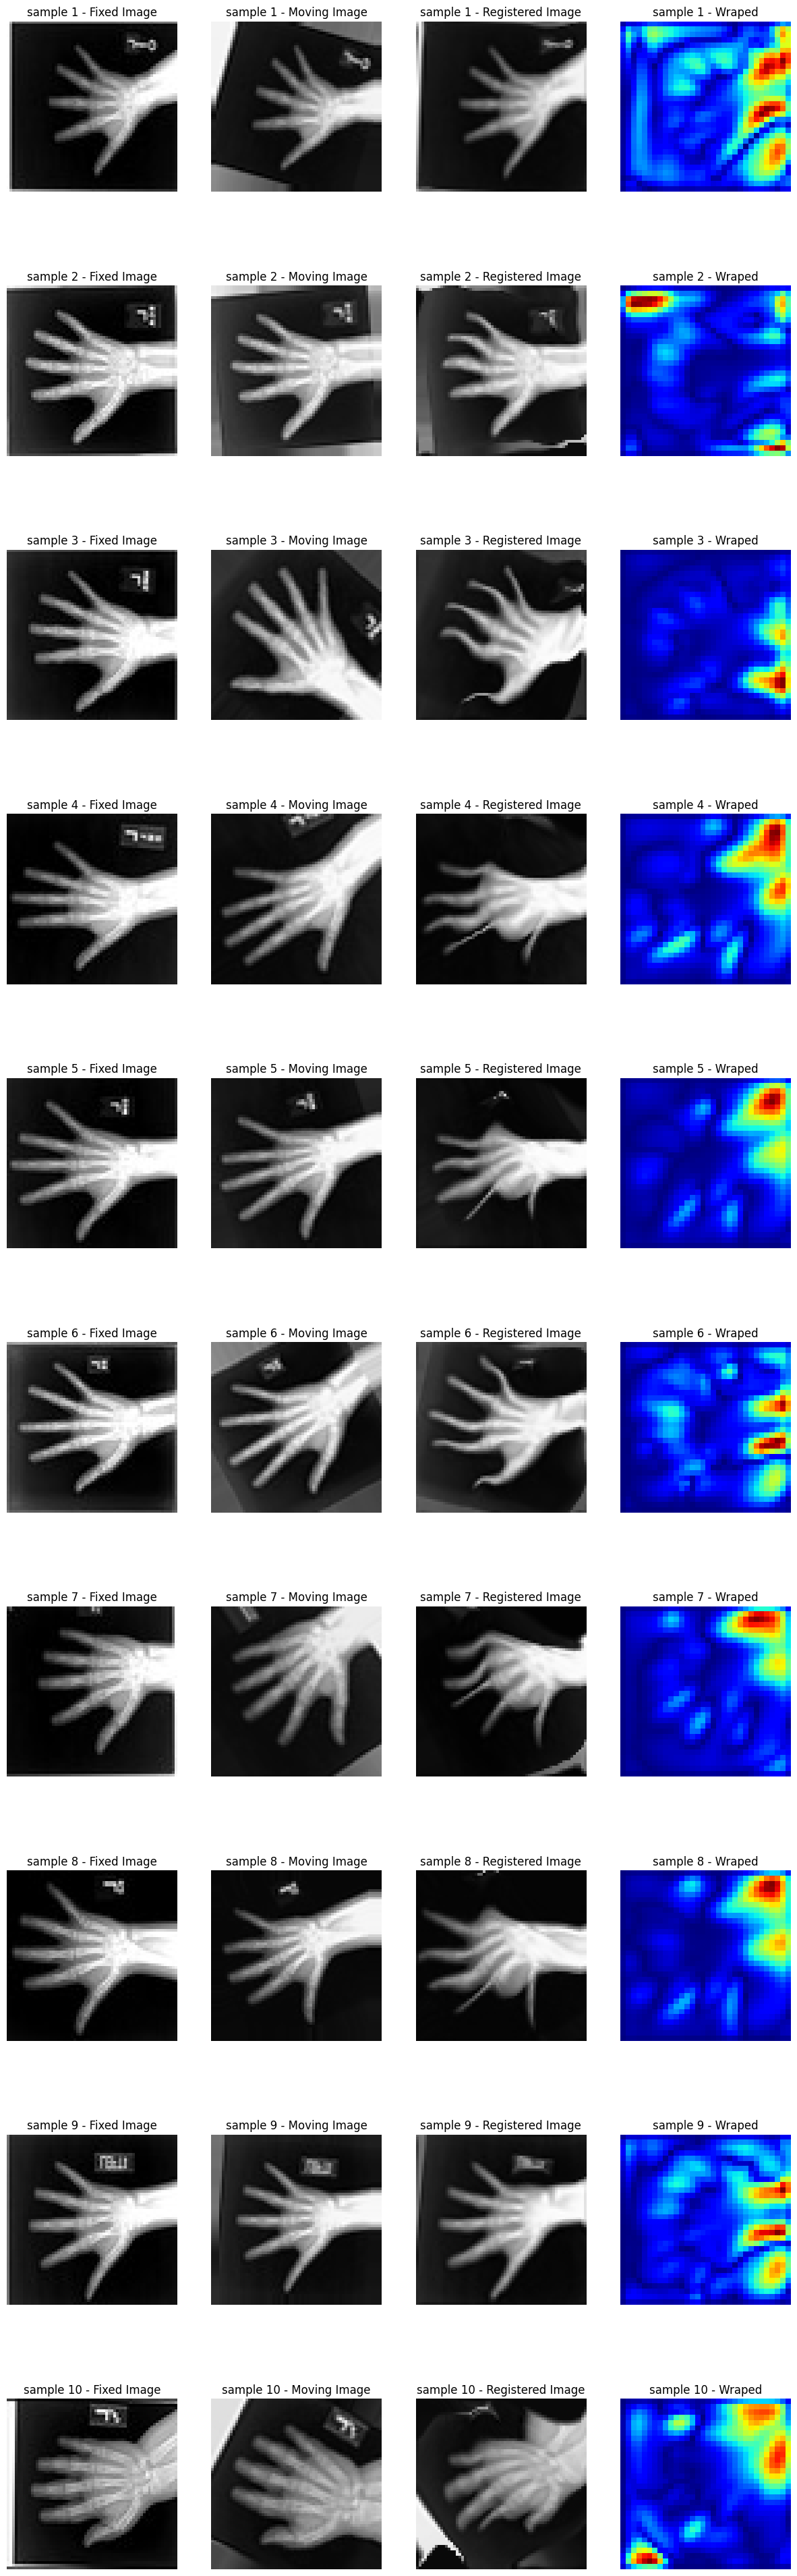

In [13]:
def plot_samples(batch_fixed, batch_moving, registered_image, dff, k):
    """
    Plot k samples from batch_fixed, batch_moving, registered_image, and deformation matrix in the validation set.
    """

    fig, axs = plt.subplots(k, 4, figsize=(15, 5 * k))

    for i in range(k):
        # Plot fixed image
        axs[i, 0].imshow(batch_fixed[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axs[i, 0].set_title(f'sample {i+1} - Fixed Image')
        axs[i, 0].axis('off')

        # Plot moving image
        axs[i, 1].imshow(batch_moving[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axs[i, 1].set_title(f'sample {i+1} - Moving Image')
        axs[i, 1].axis('off')

        # Plot registered image
        axs[i, 2].imshow(registered_image[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axs[i, 2].set_title(f'sample {i+1} - Registered Image')
        axs[i, 2].axis('off')


        displacement_magnitude = torch.norm(dff[i], dim=0).cpu().detach().numpy().squeeze()

        # Display magnitude
        axs[i, 3].imshow(displacement_magnitude, cmap='jet')
        axs[i, 3].set_title(f'sample {i+1} - Wraped')
        axs[i, 3].axis('off')

batch = next(iter(val_loader))
fixed, moving = batch['fixed_hand'].to(device), batch['moving_hand'].to(device)
register, dffs = voxelmorph(batch_moving, batch_fixed)


plot_samples(fixed, moving, register, dffs, k=10)